In [1]:
import sys

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

### 0. 파라미터

In [48]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 10
BETA = 500

### 1. 데이터 준비

In [49]:
import os
import cv2

In [50]:
PATH = "./PCBData/defects/copper"

In [51]:
images = []
for filename in os.listdir(PATH):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # 이미지 파일 형식
        img_path = os.path.join(PATH, filename)
        image = cv2.imread(img_path)
        images.append(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))  # BGR에서 RGB로 변환

# 이미지 표시 (첫 번째 이미지 예시)
cv2.imshow('Image', images[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [52]:
images[0].shape

(26, 31)

In [53]:
len(images)

1474

In [54]:
1474 * 0.8

1179.2

In [55]:
1474 - 1179

295

In [56]:
for i in range(len(images)):
    images[i] = cv2.resize(images[i], (60, 60), interpolation=cv2.INTER_LANCZOS4) 

cv2.imshow('image', images[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [57]:
images[0].shape

(60, 60)

In [58]:
imgs = [np.array(img) for img in images]

imgs = np.array(imgs)

In [59]:
imgs.dtype

dtype('uint8')

In [60]:
x_train = imgs[: 1179]
x_test = imgs[1179 :]

In [61]:
# 데이터 전처리
def preprocess(imgs):
    """
    이미지 정규화 및 크기 변경
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [62]:
print(x_train.shape, x_test.shape)

(1179, 64, 64, 1) (295, 64, 64, 1)


In [63]:
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

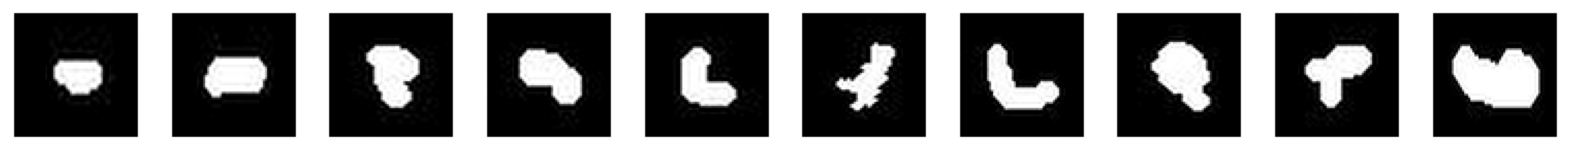

In [64]:
# 훈련 세트의 일부 의류 항목 표시
display(x_train)

### 2. 변이형 오토인코더 만들기

K : import tensorflow.keras.backend as K
backend

Keras의 백엔드 API로, 딥러닝 모델을 구축하고 훈련하는 데 필요한 다양한 기본적인 수학 연산과 텐서 조작 기능을 제공합니다. 이는 TensorFlow와 같은 저수준의 라이브러리와의 상호작용을 쉽게 만들어 주며, Keras의 고수준 API에서 사용됩니다.

In [ ]:
# K : import tensorflow.keras.backend as K
# backend

In [65]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [66]:
# 인코더
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # 디코더에 필요합니다!

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,496 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 128) │     73,856 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8192)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │     16,386 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │     16,386 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 125,444 (490.02 KB)

 Trainable params: 125,444 (490.02 KB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# 디코더
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8192)           │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 64, 64, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,705 (1.01 MB)

 Trainable params: 264,705 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """특정 입력에서 모델을 호출합니다."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """훈련 스텝을 실행합니다."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def get_config(self):
        return {}

In [69]:
# 변이형 오토인코더 생성
vae = VAE(encoder, decoder)

### 3. 변이형 오토인코더 훈련

In [70]:
# 변이형 오토인코더 컴파일
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [71]:
# 모델 저장 체크포인트 생성
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./model/autoencoder/checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [72]:
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - kl_loss: 2.3914 - reconstruction_loss: 322.8156 - total_loss: 325.2070 - val_kl_loss: 1.1739 - val_loss: 222.4827 - val_reconstruction_loss: 221.3088
Epoch 2/10
 3/37 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - kl_loss: 1.4554 - reconstruction_loss: 189.7302 - total_loss: 191.1856

c:\ProgramData\anaconda3\envs\PCB_CNN\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - kl_loss: 2.2079 - reconstruction_loss: 179.6605 - total_loss: 181.8685 - val_kl_loss: 2.5305 - val_loss: 189.2251 - val_reconstruction_loss: 186.6946
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - kl_loss: 3.4997 - reconstruction_loss: 149.4085 - total_loss: 152.9082 - val_kl_loss: 3.5052 - val_loss: 140.1472 - val_reconstruction_loss: 136.6420
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - kl_loss: 3.7940 - reconstruction_loss: 102.5565 - total_loss: 106.3505 - val_kl_loss: 2.5187 - val_loss: 119.6039 - val_reconstruction_loss: 117.0852
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - kl_loss: 3.0123 - reconstruction_loss: 89.6890 - total_loss: 92.7013 - val_kl_loss: 2.7272 - val_loss: 103.5263 - val_reconstruction_loss: 100.7990
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - kl_loss: 3.0155 - reconstruction_loss: 84.1038 - total_loss: 87.1194 - val_kl_loss: 2.9822 - val_loss: 102.4057 - val_reconstruction_loss: 99.4234
E

In [74]:
# 최종 모델 저장
vae.save("./model/autoencoder/vae.keras")
encoder.save("./model/autoencoder/encoder.keras")
decoder.save("./model/autoencoder/decoder.keras")

### 3. 변이형 오토인코더를 사용한 재구성

In [75]:
# 테스트셋의 일부를 선택합니다.
n_to_predict = 5000
example_images = x_test[:n_to_predict]
# example_labels = y_test[:n_to_predict]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
실제 결함


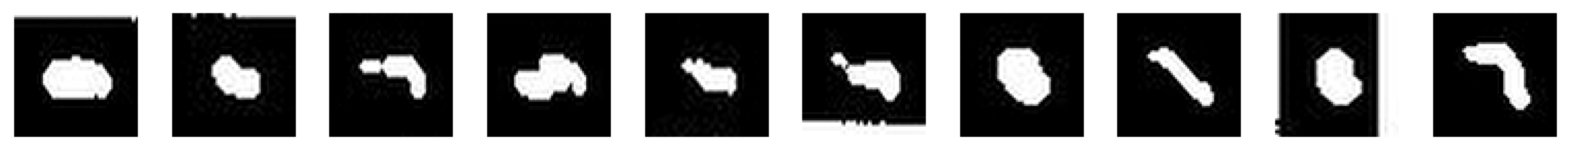

재구성 이미지


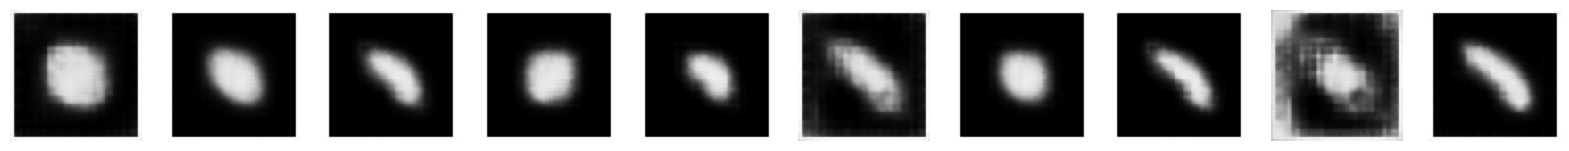

In [77]:
# 오토인코더 예측을 만들고 출력합니다.
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("실제 결함")
display(example_images)
print("재구성 이미지")
display(reconstructions)